## Imports

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from PIL import Image
import numpy as np
from tqdm import tqdm
import shutil
import gc
from IPython.display import FileLink
import time
import warnings
from torchvision.models.quantization import resnet18
from torchvision.models import resnet152
import copy
from torch.ao.quantization import QConfig
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver
from torch.quantization import QConfig, default_fake_quant, default_weight_fake_quant, get_default_qconfig, prepare
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Pre-processing

In [17]:
def preprocess_and_save(root_dir, category, label, output_dir, transform):
    
    os.makedirs(output_dir, exist_ok = True)
    metadata = []

    category_path = os.path.join(root_dir, category)
    
    if os.path.isdir(category_path):
        for file_name in tqdm(os.listdir(category_path), desc = f"Processing {category}"):
            
            if file_name.endswith(".png"):
                img_path = os.path.join(category_path, file_name)
                image = Image.open(img_path).convert("RGB")
                image = transform(image)  

                tensor_path = os.path.join(output_dir, f"{file_name}.pt")
                torch.save(image, tensor_path)

                metadata.append((tensor_path, label))

    metadata_path = os.path.join(output_dir, f"{category}_metadata.pt")
    torch.save(metadata, metadata_path)

    zip_path = shutil.make_archive(output_dir, 'zip', output_dir)

    return zip_path  

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

label_map = {"safe": 0, "drugs": 1, "gore": 2, "nude": 3, "violence": 4}

dataset_type = input("Enter dataset type to process (train/test):").strip().lower()
if dataset_type == "train": root_dir = "/kaggle/input/dlsprojectdataset/dlsProjectDataset/train"
elif dataset_type == "test": root_dir = "/kaggle/input/dlsprojectdataset/dlsProjectDataset/test"

categories_to_process = input("Enter categories to process (comma-separated):").split(",")

for category in categories_to_process:
    
    category = category.strip() 
    
    if category in label_map:
        print(f"Processing category: {category} in {dataset_type} dataset.")
        label = label_map[category]
        output_dir = f"/kaggle/working/processed_{dataset_type}_{category}"  
        
        zip_path = preprocess_and_save(root_dir, category, label, output_dir, transform)

        print(f"Finished processing {category}. Zipped file saved at {zip_path}.")

Enter dataset type to process (train/test): test
Enter categories to process (comma-separated): violence


Processing category: violence in test dataset.


Processing violence: 100%|██████████| 3294/3294 [00:48<00:00, 67.68it/s]


Finished processing violence. Zipped file saved at /kaggle/working/processed_test_violence.zip.


In [32]:
file_name = "/kaggle/working/processed_test_violence.zip"
FileLink(file_name)

/kaggle/working/processed_test_violence.zip

In [33]:
directory = "/kaggle/working/processed_test_violence"

if os.path.exists(directory):
    shutil.rmtree(directory)
    print(f"Deleted directory: {directory}")
else:
    print(f"Directory not found: {directory}")

Deleted directory: /kaggle/working/processed_test_violence


# ResNet-18

## Model Implementation (Base Model)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label_map, batch_size, data_type, device, shuffle = False):
        
        self.root_dir = root_dir
        self.label_map = label_map
        self.batch_size = batch_size
        self.data_type = data_type
        self.shuffle = shuffle
        self.device = device

        self.data = []
        self.labels = []

        for category, label in self.label_map.items():
            category_dir = os.path.join(root_dir, f"processed_{data_type}_{category}")
            
            if os.path.isdir(category_dir):
                for file_name in os.listdir(category_dir):
                    
                    if file_name.endswith(".pt") and not file_name.endswith("metadata.pt"): 
                        file_path = os.path.join(category_dir, file_name)
                        self.data.append(file_path)
                        self.labels.append(label)

        if self.shuffle: self.shuffle_data()

    def shuffle_data(self):
        indices = torch.randperm(len(self.data))
        self.data = [self.data[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, len(self.data))
        
        batch_x = []
        batch_y = []

        for i in range(start, end):
            
            image_tensor = torch.load(self.data[i])
            image_tensor = image_tensor.to(self.device)
            batch_x.append(image_tensor)
            batch_y.append(self.labels[i])
        
        batch_x = torch.stack(batch_x)
        batch_y = torch.tensor(batch_y, device = self.device)
        
        return batch_x, batch_y


class CustomDataLoader(DataLoader):
    def __init__(self, dataset, *args, **kwargs):
        self.dataset = dataset
        super().__init__(dataset, *args, **kwargs)

    def __iter__(self):
        self.dataset.shuffle_data()
        return super().__iter__()

In [4]:
label_map = {"safe": 0, "drugs": 1, "gore": 2, "nude": 3, "violence": 4}

train_folder = "/kaggle/input/dls-data-processed-train/processed_train"
test_folder = "/kaggle/input/dls-data-processed-test/processed_test"

train_dataset = CustomDataset(train_folder, label_map, 64, "train", device, shuffle = True)
test_dataset = CustomDataset(test_folder, label_map,  64, "test", device, shuffle = False)

train_loader = CustomDataLoader(train_dataset, batch_size = None, shuffle = False)
test_loader = CustomDataLoader(test_dataset, batch_size = None, shuffle = False)

In [5]:
for batch_x, batch_y in train_loader:
    print(f"Batch X shape: {batch_x.shape}, Batch Y shape: {batch_y.shape}")
    break

Batch X shape: torch.Size([64, 3, 320, 320]), Batch Y shape: torch.Size([64])


In [6]:
print(f"Number of batches in the train dataset: {len(train_loader)}")
print(f"Number of batches in the test dataset: {len(test_loader)}")

Number of batches in the train dataset: 437
Number of batches in the test dataset: 179


In [7]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs, device):
    
    loss_function = nn.CrossEntropyLoss()
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
    total_time = 0

    for epoch in range(num_epochs): 
        
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        epoch_accuracy = 100 * correct / total
        epoch_loss = train_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        total_time += epoch_time
            
        test_loss, test_accuracy = evaluate_model(model, test_loader, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "f"Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}% | "f"Test Accuracy: {test_accuracy:.2f}% | Training Time: {epoch_time:.2f}s")

    avg_time = total_time / num_epochs
    print(f"\nTotal Training Time: {total_time:.2f}s")
    print(f"Average Training Time per epoch: {avg_time:.2f}s")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [8]:
def evaluate_model(model, test_loader, device):
    
    model.eval()  
    eval_loss = 0.0
    correct = 0
    total = 0
    loss_function = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    eval_accuracy = 100 * correct / total

    return eval_loss / len(test_loader), eval_accuracy

In [9]:
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes = 5, freeze_backbone = True):
        super(ResNet18Classifier, self).__init__()

        self.backbone = resnet18(pretrained = True)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [10]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True).to(device)
optimizer_ResNet18 = optim.Adam(model_ResNet18.parameters(), lr = 1e-3)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model_ResNet18, train_loader, test_loader, optimizer_ResNet18, 15, device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


Epoch [1/15] - Loss: 0.3961 | Train Accuracy: 85.59% | Test Accuracy: 90.49% | Training Time: 580.32s
Epoch [2/15] - Loss: 0.2595 | Train Accuracy: 90.64% | Test Accuracy: 91.90% | Training Time: 324.22s
Epoch [3/15] - Loss: 0.2274 | Train Accuracy: 91.69% | Test Accuracy: 92.25% | Training Time: 302.73s
Epoch [4/15] - Loss: 0.2022 | Train Accuracy: 92.61% | Test Accuracy: 92.44% | Training Time: 272.81s
Epoch [5/15] - Loss: 0.1918 | Train Accuracy: 93.12% | Test Accuracy: 93.14% | Training Time: 263.56s
Epoch [6/15] - Loss: 0.1776 | Train Accuracy: 93.44% | Test Accuracy: 93.06% | Training Time: 288.56s
Epoch [7/15] - Loss: 0.1673 | Train Accuracy: 94.00% | Test Accuracy: 94.08% | Training Time: 260.80s
Epoch [8/15] - Loss: 0.1500 | Train Accuracy: 94.41% | Test Accuracy: 92.84% | Training Time: 271.95s
Epoch [9/15] - Loss: 0.1466 | Train Accuracy: 94.69% | Test Accuracy: 94.22% | Training Time: 282.30s
Epoch [10/15] - Loss: 0.1369 | Train Accuracy: 95.00% | Test Accuracy: 94.59% | Tr

In [11]:
torch.save(model_ResNet18.state_dict(), os.path.join('/kaggle/working/', 'resnet18.pth'))
pth_file = '/kaggle/working/resnet18.pth'
zip_path = shutil.make_archive('/kaggle/working/resnet18', 'zip', os.path.dirname(pth_file), os.path.basename(pth_file))

In [12]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True)
model_ResNet18.load_state_dict(torch.load('/kaggle/input/resnet18-weights/resnet18.pth', map_location = device, weights_only = True))
model_ResNet18.to(device)
model_ResNet18.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ResNet18(inputs)  
        preds = torch.argmax(outputs, dim = 1)  

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

prec = precision_score(all_labels, all_preds, average = 'weighted')
rec = recall_score(all_labels, all_preds, average = 'weighted')
f1 = f1_score(all_labels, all_preds, average = 'weighted')

In [14]:
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9428
Recall: 0.9410
F1-score: 0.9409


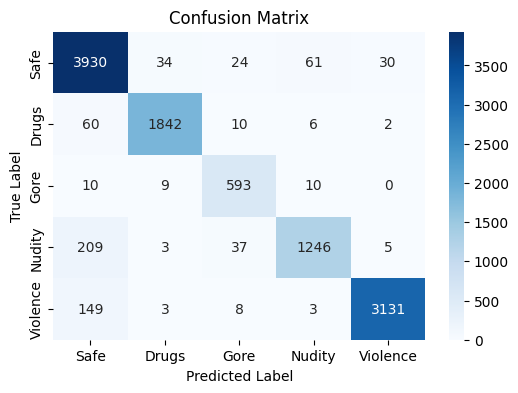

In [19]:
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Safe', 'Drugs', 'Gore', 'Nudity', 'Violence']  

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Quantization-Aware Training (QAT)

In [10]:
def fuse_resnet18_layers(fused_model):

    fused_model.backbone = torch.quantization.fuse_modules(fused_model.backbone, [["conv1", "bn1", "relu"]], inplace = True)
    
    for module_name, module in fused_model.backbone.named_children():
        
        if "layer" in module_name:
            for basic_block_name, basic_block in module.named_children():
                torch.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu"], ["conv2", "bn2"]], inplace = True)
                
                for sub_block_name, sub_block in basic_block.named_children():
                    if sub_block_name == "downsample":
                        torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace = True)

    return fused_model

In [15]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True)
model_ResNet18.load_state_dict(torch.load('/kaggle/input/resnet18-weights/resnet18.pth', map_location = device, weights_only = True))
model_ResNet18.to("cpu")
fused_model = copy.deepcopy(model_ResNet18)

model_ResNet18.eval()
fused_model.eval()

fused_model = fuse_resnet18_layers(fused_model)

In [11]:
def model_equivalence(model_1, model_2, device, rtol = 1e-05, atol = 1e-08, num_tests = 100, input_size = (1, 3, 320, 320)):

    model_1.to(device)
    model_2.to(device)

    for _ in range(num_tests):
        x = torch.rand(size = input_size).to(device)
        y1 = model_1(x).detach().cpu().numpy()
        y2 = model_2(x).detach().cpu().numpy()
        
        if np.allclose(a = y1, b = y2, rtol = rtol, atol = atol, equal_nan = False) == False:
            print("Model equivalence test sample failed: ")
            print(y1)
            print(y2)
            return False

    return True

In [17]:
print(model_equivalence(model_1 = model_ResNet18, model_2 = fused_model, device = "cpu", rtol = 1e-03, atol = 1e-06, num_tests = 50, input_size = (1, 3, 320, 320)))

True


In [12]:
def prepare_qat_model(fused_model, device):

    my_qconfig = QConfig(
        activation = default_fake_quant,
        weight = default_weight_fake_quant.with_args(qscheme = torch.per_tensor_affine)
    )
    
    fused_model.qconfig = my_qconfig
        
    fused_model.train() 
    torch.quantization.prepare_qat(fused_model, inplace = True)
    fused_model.to(device)

    return fused_model

In [13]:
def train_qat_model(model, train_loader, test_loader, optimizer, num_epochs, device):
    
    loss_function = nn.CrossEntropyLoss()

    total_start_time = time.time()

    for epoch in range(num_epochs): 
        
        epoch_start_time = time.time()
        
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        epoch_accuracy = 100 * correct / total
        epoch_loss = train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}% | Training Time: {epoch_time:.2f}s")

    total_end_time = time.time()
    total_time = total_end_time - total_start_time
    avg_time = total_time / num_epochs
    print(f"\nTotal Training Time: {total_time:.2f}s")
    print(f"Average Training Time per epoch: {avg_time:.2f}s")

In [18]:
qat_model = prepare_qat_model(fused_model, device)

optimizer_qat = optim.Adam(qat_model.parameters(), lr = 1e-5)
train_qat_model(qat_model, train_loader, test_loader, optimizer_qat, 15, device)

Epoch [1/15] - Loss: 0.1096 | Train Accuracy: 95.91% | Training Time: 297.58s
Epoch [2/15] - Loss: 0.0977 | Train Accuracy: 96.52% | Training Time: 256.82s
Epoch [3/15] - Loss: 0.0886 | Train Accuracy: 96.84% | Training Time: 189.50s
Epoch [4/15] - Loss: 0.0843 | Train Accuracy: 96.97% | Training Time: 177.49s
Epoch [5/15] - Loss: 0.0805 | Train Accuracy: 97.11% | Training Time: 181.32s
Epoch [6/15] - Loss: 0.0782 | Train Accuracy: 97.08% | Training Time: 183.87s
Epoch [7/15] - Loss: 0.0761 | Train Accuracy: 97.27% | Training Time: 185.46s
Epoch [8/15] - Loss: 0.0753 | Train Accuracy: 97.27% | Training Time: 183.42s
Epoch [9/15] - Loss: 0.0746 | Train Accuracy: 97.35% | Training Time: 188.16s
Epoch [10/15] - Loss: 0.0722 | Train Accuracy: 97.39% | Training Time: 188.51s
Epoch [11/15] - Loss: 0.0723 | Train Accuracy: 97.43% | Training Time: 190.26s
Epoch [12/15] - Loss: 0.0732 | Train Accuracy: 97.33% | Training Time: 178.74s
Epoch [13/15] - Loss: 0.0726 | Train Accuracy: 97.31% | Train

In [19]:
torch.save(qat_model.state_dict(), os.path.join('/kaggle/working/', 'qat_resnet18.pth'))
pth_file = '/kaggle/working/qat_resnet18.pth'
zip_path = shutil.make_archive('/kaggle/working/qat_resnet18', 'zip', os.path.dirname(pth_file), os.path.basename(pth_file))

In [14]:
def convert_to_quantized_model(model):
    
    model.eval()
    quantized_model = torch.quantization.convert(model, inplace = True)

    for name, param in quantized_model.named_parameters():
        param.data = param.data.to("cpu")
    for name, buffer in quantized_model.named_buffers():
        buffer.data = buffer.data.to("cpu")

    return quantized_model

In [15]:
def evaluate_qat_model(model, test_loader, device = "cpu"):

    model.eval()
    model.to(device)
    
    eval_loss = 0.0
    correct = 0
    total = 0
    loss_function = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    eval_accuracy = 100 * correct / total
    eval_loss = eval_loss / len(test_loader)

    return eval_loss, eval_accuracy

In [16]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True)
model_ResNet18.load_state_dict(torch.load('/kaggle/input/resnet18-weights/resnet18.pth', map_location = device, weights_only = True))
model_ResNet18.to("cpu")
fused_model = copy.deepcopy(model_ResNet18)

model_ResNet18.eval()
fused_model.eval()

fused_model = fuse_resnet18_layers(fused_model)

qat_model = prepare_qat_model(fused_model, device)
qat_model.load_state_dict(torch.load("/kaggle/input/qat-resnet18-weights/qat_resnet18.pth", map_location = device, weights_only = True))  

quantized_model = convert_to_quantized_model(fused_model)
quantized_model.to("cpu")

test_loss, test_accuracy = evaluate_qat_model(quantized_model, test_loader, device = "cpu")
print(f"Quantized Model Accuracy: {test_accuracy:.2f}%")

Quantized Model Accuracy: 95.10%


In [27]:
torch.save(quantized_model.state_dict(), os.path.join('/kaggle/working/', 'quantized_model.pth'))
pth_file = '/kaggle/working/quantized_model.pth'
zip_path = shutil.make_archive('/kaggle/working/quantized_model', 'zip', os.path.dirname(pth_file), os.path.basename(pth_file))

In [18]:
def measure_latency(model, device, input_size = (1, 3, 224, 224), num_samples = 100):
    
    model.eval().to(device)
    input_data = torch.rand(input_size).to(device)
    
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)
        torch.cuda.synchronize() if device == "cuda" else None
        
        start_time = time.time()
        for _ in range(num_samples):
            _ = model(input_data)
        torch.cuda.synchronize() if device == "cuda" else None
        end_time = time.time()
        
    avg_latency = (end_time - start_time) / num_samples * 1000  
    
    return avg_latency

In [28]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True)
model_ResNet18.load_state_dict(torch.load('/kaggle/input/resnet18-weights/resnet18.pth', map_location = device, weights_only = True))
fp32_latency = measure_latency(model_ResNet18, device = "cpu")
print(f"FP32 CPU Latency: {fp32_latency:.2f} ms/sample")

FP32 CPU Latency: 51.22 ms/sample


In [11]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True)
model_ResNet18.load_state_dict(torch.load('/kaggle/input/resnet18-weights/resnet18.pth', map_location = device, weights_only = True))
fp32_latency = measure_latency(model_ResNet18, device = device)
print(f"FP32 CUDA Latency: {fp32_latency:.2f} ms/sample")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


FP32 CUDA Latency: 2.35 ms/sample


In [29]:
quantized_latency = measure_latency(quantized_model, device = "cpu")
print(f"Quantized Latency: {quantized_latency:.2f} ms/sample")

Quantized Latency: 25.66 ms/sample


In [18]:
def save_torchscript_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok = True)
    model_filepath = os.path.join(model_dir, model_filename)

    model.to("cpu")
    model.eval()

    scripted_model = torch.jit.script(model)
    torch.jit.save(scripted_model, model_filepath)

def load_torchscript_model(model_filepath, device = "cpu"):
   
    model = torch.jit.load(model_filepath, map_location=device)
    model.eval()
    
    return model

In [19]:
save_torchscript_model(quantized_model, '/kaggle/working', 'quantized_jit')

In [26]:
model_quantized_jit = load_torchscript_model(os.path.join('/kaggle/working', 'quantized_jit'), device = "cpu")

In [30]:
quantized_latency_jit = measure_latency(model_quantized_jit, device = "cpu")
print(f"Quantized Latency: {quantized_latency_jit:.2f} ms/sample")

Quantized Latency: 22.18 ms/sample


## Post-Training Quantization (Static Quantization)

In [19]:
model_ResNet18 = ResNet18Classifier(num_classes = 5, freeze_backbone = True)
model_ResNet18.load_state_dict(torch.load('/kaggle/input/resnet18-weights/resnet18.pth', map_location = device, weights_only = True))
model_ResNet18.to("cpu")
fused_model = copy.deepcopy(model_ResNet18)

model_ResNet18.eval()
fused_model.eval()

fused_model = fuse_resnet18_layers(fused_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [20]:
print(model_equivalence(model_1 = model_ResNet18, model_2 = fused_model, device = "cpu", rtol = 1e-03, atol = 1e-06, num_tests = 50, input_size = (1, 3, 320, 320)))

True


In [21]:
def prepare_static_model(fused_model, device):

    qconfig = get_default_qconfig('fbgemm')
    fused_model.qconfig = qconfig

    fused_model.eval()

    prepare(fused_model, inplace = True)
    fused_model.to(device)

    return fused_model

In [22]:
static_model = prepare_static_model(fused_model, device)

In [23]:
def calibrate_model(model, train_loader, device = "cpu", num_batches = 5):
    
    model.to(device)
    model.eval()

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= num_batches:
            break  
        inputs = inputs.to(device)
        _ = model(inputs)  

In [24]:
calibrate_model(static_model, train_loader, device = "cpu", num_batches = 5)

In [25]:
quantized_model = convert_to_quantized_model(fused_model)
quantized_model.to("cpu")

test_loss, test_accuracy = evaluate_qat_model(quantized_model, test_loader, device = "cpu")
print(f"Quantized Model Accuracy: {test_accuracy:.2f}%")

Quantized Model Accuracy: 93.83%


In [26]:
quantized_latency = measure_latency(quantized_model, device = "cpu")
print(f"Quantized Latency: {quantized_latency:.2f} ms/sample")

Quantized Latency: 21.90 ms/sample


In [29]:
save_torchscript_model(quantized_model, '/kaggle/working', 'quantized_jit')
model_quantized_jit = load_torchscript_model(os.path.join('/kaggle/working', 'quantized_jit'), device = "cpu")

In [30]:
quantized_latency_jit = measure_latency(model_quantized_jit, device = "cpu")
print(f"Quantized Latency: {quantized_latency_jit:.2f} ms/sample")

Quantized Latency: 19.84 ms/sample


# CNN

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes = 5):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2) 
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)  
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)  
        )
 
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)  
        x = torch.flatten(x, start_dim = 1) 
        x = self.fc(x)
        
        return x

In [10]:
model_cnnclassifier = CNNClassifier(num_classes = 5).to(device)
optimizer_cnnclassifier = optim.Adam(model_cnnclassifier.parameters(), lr = 1e-3)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model_cnnclassifier, train_loader, test_loader, optimizer_cnnclassifier, 15, device)

Epoch [1/15] - Loss: 0.9934 | Train Accuracy: 61.57% | Test Accuracy: 55.82% | Training Time: 571.15s
Epoch [2/15] - Loss: 0.7890 | Train Accuracy: 70.27% | Test Accuracy: 67.90% | Training Time: 365.84s
Epoch [3/15] - Loss: 0.6930 | Train Accuracy: 74.39% | Test Accuracy: 72.49% | Training Time: 339.96s
Epoch [4/15] - Loss: 0.6401 | Train Accuracy: 76.43% | Test Accuracy: 75.96% | Training Time: 334.37s
Epoch [5/15] - Loss: 0.5995 | Train Accuracy: 78.07% | Test Accuracy: 72.01% | Training Time: 303.53s
Epoch [6/15] - Loss: 0.5653 | Train Accuracy: 79.20% | Test Accuracy: 74.25% | Training Time: 317.75s
Epoch [7/15] - Loss: 0.5405 | Train Accuracy: 80.35% | Test Accuracy: 79.82% | Training Time: 313.78s
Epoch [8/15] - Loss: 0.5270 | Train Accuracy: 80.77% | Test Accuracy: 81.56% | Training Time: 310.82s
Epoch [9/15] - Loss: 0.5045 | Train Accuracy: 81.60% | Test Accuracy: 69.74% | Training Time: 338.28s
Epoch [10/15] - Loss: 0.4923 | Train Accuracy: 82.22% | Test Accuracy: 80.72% | Tr

In [12]:
torch.save(model_cnnclassifier.state_dict(), os.path.join('/kaggle/working/', 'cnn.pth'))
pth_file = '/kaggle/working/cnn.pth'
zip_path = shutil.make_archive('/kaggle/working/cnn', 'zip', os.path.dirname(pth_file), os.path.basename(pth_file))